<a href="https://colab.research.google.com/github/SnorrenanxD/FACT_43/blob/linus/dinov2_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/facebookresearch/dinov2

fatal: destination path 'dinov2' already exists and is not an empty directory.


In [ ]:
# not really necessary at this moment

# !git clone https://github.com/fastai/imagenette.git

In [2]:
!pip install -r dinov2/requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117, https://pypi.nvidia.com


In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!mkdir data
!tar -xf imagenette2.tgz --strip-components=1 -C data

--2025-01-13 16:39:29--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.248, 54.231.171.136, 52.216.53.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  35.4MB/s    in 41s     

2025-01-13 16:40:10 (36.3 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]



In [1]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

In [2]:
device = torch.device("cuda")
folder_path = 'data/val'

## Utilities

In [3]:
# @title define preprocessing
class ResizeToMultiple:
  def __init__(self, multiple: int):
    self.multiple = multiple

  def __call__(self, img: Image.Image) -> Image.Image:
    width, height = img.size
    new_width = (width // self.multiple) * self.multiple
    new_height = (height // self.multiple) * self.multiple
    resize_transform = transforms.Resize((new_height, new_width))
    return resize_transform(img)

# Define preprocessing transformations
preprocess = transforms.Compose([
  ResizeToMultiple(14),
  transforms.ToTensor(),          # Convert image to PyTorch tensor
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Define preprocessing transformations
preprocess_batch = transforms.Compose([
  transforms.Resize((252, 252)),
  transforms.ToTensor(),          # Convert image to PyTorch tensor
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [20]:
# @title generate attention maps
def get_attention_maps(model,
                       input_tensor,
                       layers: list[int],
                       truncate_norms: int|bool = False):
  # Perform forward pass to get attention maps
    with torch.no_grad():
      output = model.get_intermediate_layers(input_tensor,
                                              n=layers,
                                              reshape=True,
                                              return_class_token=False,
                                              norm=False)

    att_maps = []
    norms_list = []
    layer_list = []
    # For each layer, extract feature vector and compute norms
    for n, layer in enumerate(output):
      # attention maps have shape [embedding_dim, height, width], reorder to have embedding channel last
      att = layer.squeeze().cpu().numpy().transpose(1, 2, 0)
      print(att.shape)
      norms = np.linalg.norm(att, ord=np.inf, axis=2)
      # norms = np.linalg.norm(att, axis=2)
      print(norms.shape)
      if truncate_norms:
        norms = np.clip(norms, 0, truncate_norms)
      norms_list.append(norms.flatten())
      att_maps.append(norms)
      layer_list.extend([n]*np.prod(norms.shape))

    norms_list = np.array(norms_list).flatten()
    layer_list = np.array(layer_list)

    return att_maps, norms_list, layer_list

In [5]:
# @title Visualize attention maps
def visualize_attention_maps(model,
                             images,
                             layers_to_visualize,
                             truncate_norms=0,
                             show_norms=False,
                             output_format="auto",
                             **kwargs):

  device = torch.device("cuda")
  layers_total = model.n_blocks
  i_offset = 2 if show_norms else 1

  model.to(device)
  if output_format == "auto":
    output_format = ((len(layers_to_visualize)+i_offset)*2, len(images)*2)

  # Set up the plot with an extra column for the norms
  fig, ax = plt.subplots(len(images), i_offset + len(layers_to_visualize),
                          figsize=output_format)

  # reshape plt axes in case of a single row
  if len(images) == 1:
    ax = ax.reshape(1, -1)

  for n_image, image in enumerate(images):
    # Apply preprocessing
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)

    att_maps, norms_list, layer_list = get_attention_maps(model,
                                                          input_tensor,
                                                          layers_total,
                                                          truncate_norms)

    # Display the original image
    ax[n_image, 0].imshow(np.array(image))
    ax[n_image, 0].axis('off')

    # Optionally display the norm distribution across layers
    if show_norms:
      heatmap, xedges, yedges = np.histogram2d(layer_list, norms_list,
                                               bins=[layers_total, 50])
      heatmap[heatmap == 0] = heatmap[heatmap > 0].min()/10
      ax[n_image, 1].imshow(heatmap.T, aspect=0.7, cmap='viridis',
                            origin='lower', norm=LogNorm())
      ax[n_image, 1].xaxis.set_visible(False)

    # Display the attention maps for each layer
    for n, i_map in enumerate(layers_to_visualize):
      ax[n_image, n+i_offset].imshow(att_maps[i_map], norm=LogNorm())
      ax[n_image, n+i_offset].axis('off')

  # Set titles only to first row
  ax[0, 0].set_title('Input Image')
  if show_norms:
    ax[0, 1].set_title('Norm Distribution')
    ax[-1, 1].xaxis.set_visible(True)
    ax[-1, 1].set_xlabel('Layer')
  for i in range(len(layers_to_visualize)):
    ax[0, i+i_offset].set_title(f'Layer {layers_to_visualize[i]}')

  plt.tight_layout()
  plt.show()

In [6]:
# @title get image paths
def get_paths_in_subfolders(folder_path: str,
                            flat: bool = False
                            ) -> list[list[str]] | list[str]:
  """Given a folder path, returns a list of all image paths in the subfolders.

  Args:
    folder_path: The path to the folder.
    flat: If True, returns a list of all image paths in the subfolders.
          If False, returns a nested list of all image paths in the subfolders.

  Returns:
    A list of all image paths in the subfolders.
  """

  files= []
  # Iterate through the subfolders in the given folder
  for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    folder : list[str] = []
    if os.path.isdir(subfolder_path):
      for file_ in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, file_)
        folder.append(file_path)

    if flat:
      files.extend(folder)
    else:
      files.append(folder)

  return files

In [10]:
# @title generate average norms
def visualize_average_norms(model, image_batches, truncate_norms: int | bool = False):
  model.to(device)
  layers_total = model.n_blocks
  norms_list = []
  layers_list = []

  for images in image_batches:
    images = images.to(device)
    with torch.no_grad():
      output = model.get_intermediate_layers(images,
                                              n=model.n_blocks,
                                              reshape=False,
                                              return_class_token=False,
                                              norm=False)

    # For each layer, extract feature vector and compute norms
    for n, layer in enumerate(output):
      att = layer.cpu().numpy() # (batch, tokens, embed_dim)
      norms = np.linalg.norm(att, axis=2).reshape((-1,)) # (batch*tokens)
      if truncate_norms:
        norms = np.clip(norms, 0, truncate_norms)

      norms_list.extend(norms.tolist())
      layers_list.extend([n]*np.prod(norms.shape))

  norms_array = np.array(norms_list)
  layers_array = np.array(layers_list)


  heatmap, xedges, yedges = np.histogram2d(layers_array, norms_array,
                                              bins=[layers_total, 50])
  heatmap[heatmap == 0] = heatmap[heatmap > 0].min()/10
  plt.imshow(heatmap.T, aspect=0.7, cmap='viridis',
                      origin='lower', norm=LogNorm())
  plt.xlabel('Layer')
  plt.ylabel('Norm')
  plt.title('Norm Distribution Across Layers')
  plt.show()


## Setup

In [8]:
image_paths = get_paths_in_subfolders(folder_path)
sample_images = [Image.open(path[0]).convert("RGB") for path in image_paths]

### Load Large

In [ ]:
dinov2_large = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_large.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:15<00:00, 77.0MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [ ]:
dinov2_large_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
dinov2_large_reg.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_reg4_pretrain.pth
100%|██████████| 1.13G/1.13G [00:55<00:00, 21.8MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


### Load Giant

In [9]:
dinov2_giant = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dinov2_giant.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [9]:
dinov2_giant_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
dinov2_giant_reg.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

## Evaluate models on small sample

In [ ]:
layers_large = dinov2_large.n_blocks
layers_giant = dinov2_giant.n_blocks

n_samples = 10

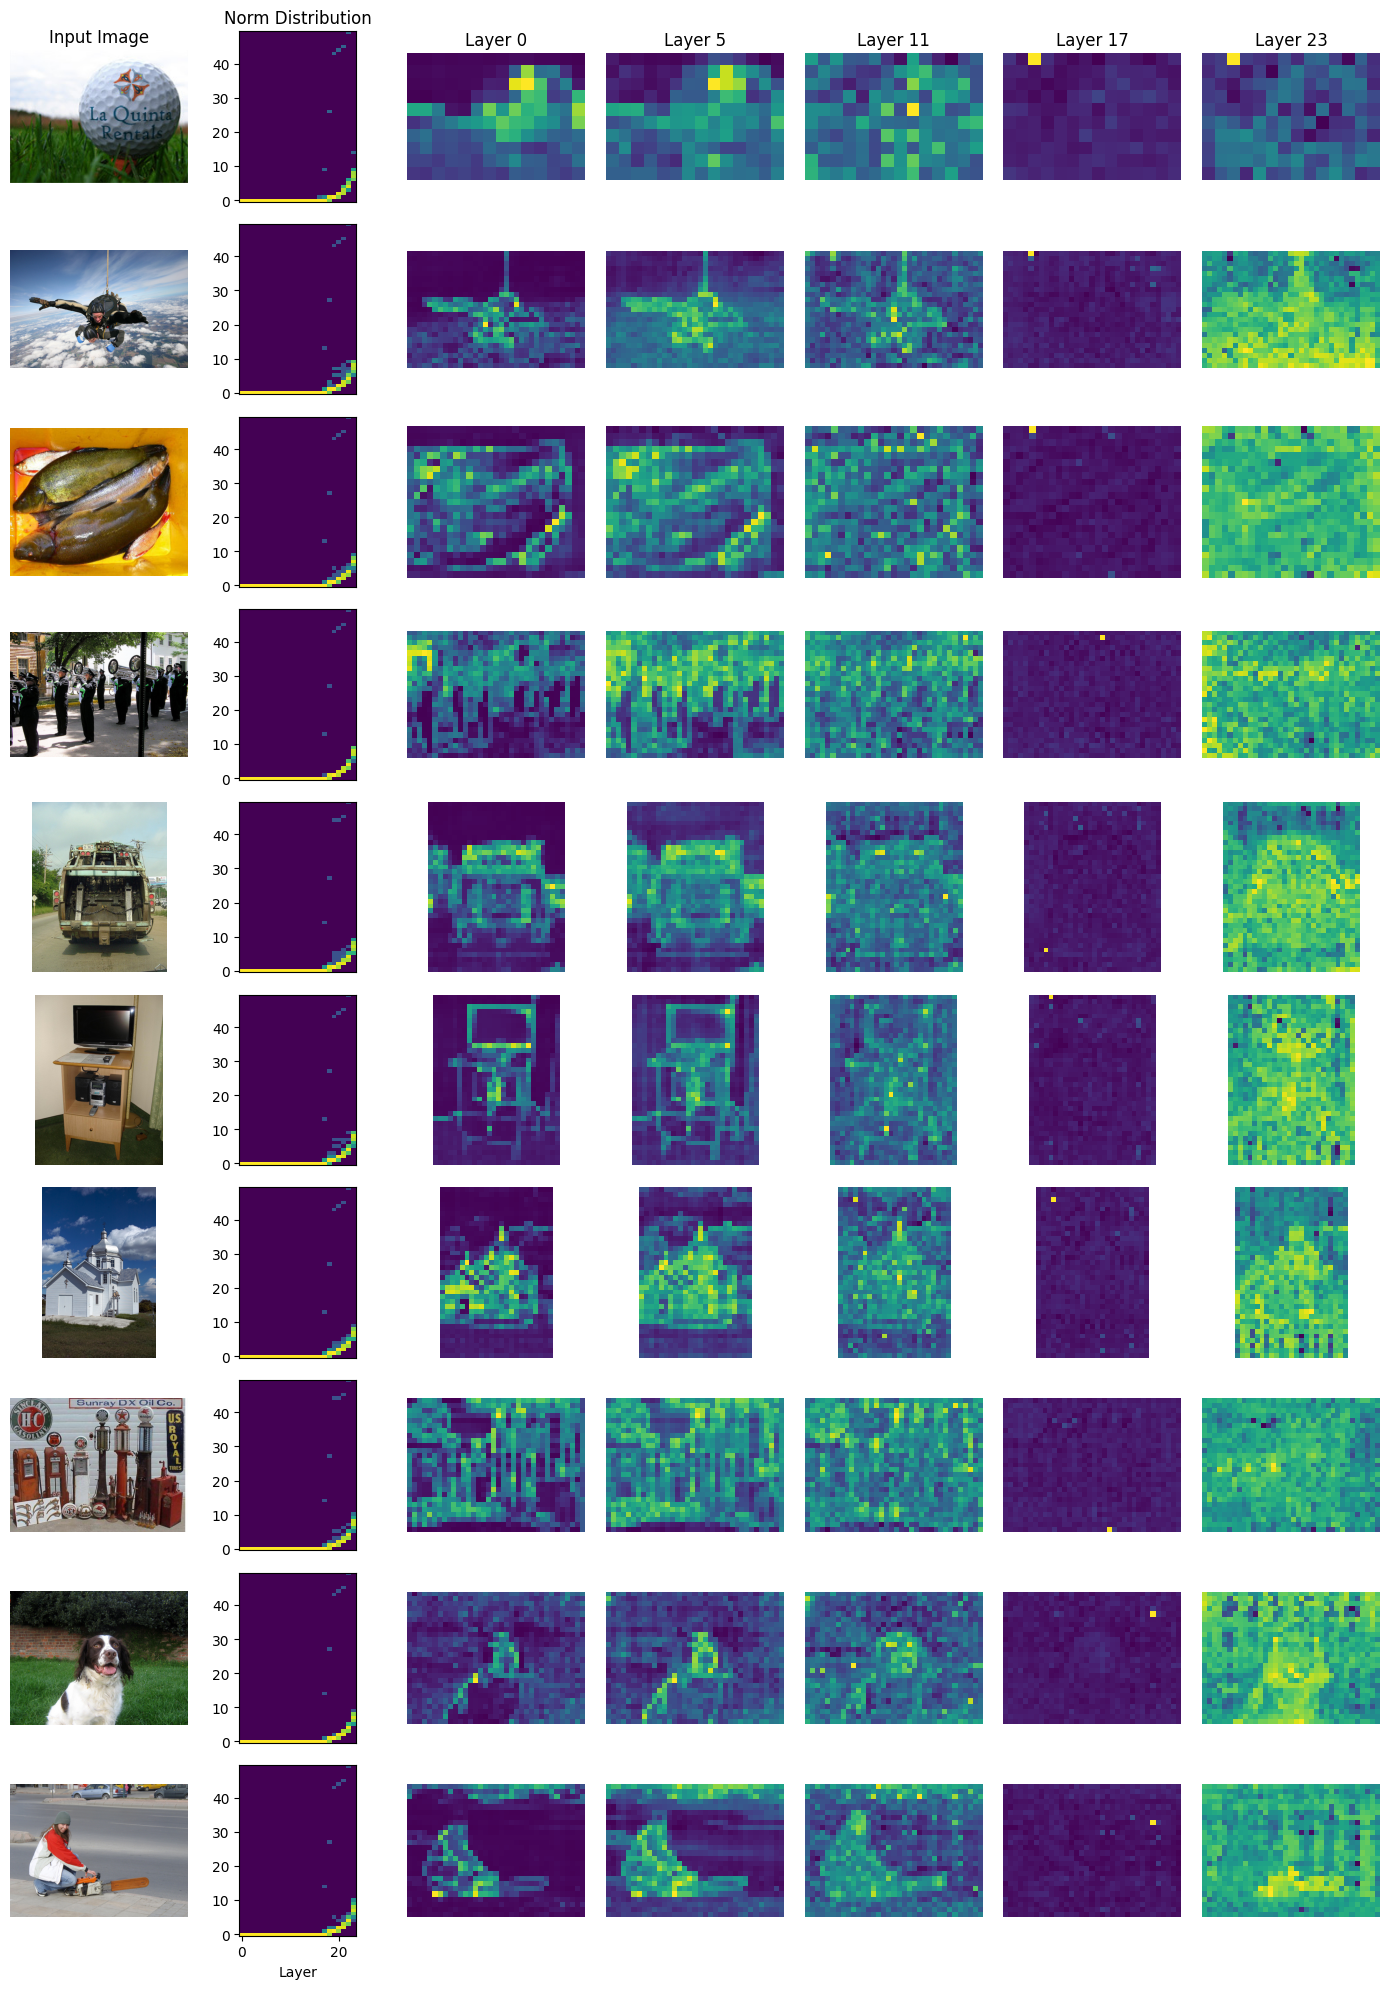

In [ ]:
visualize_attention_maps(dinov2_large,
                         sample_images[:n_samples],
                         layers_to_visualize=(0, 5, 11, 17, 23),
                         show_norms=True,
                         truncate_norms=300)

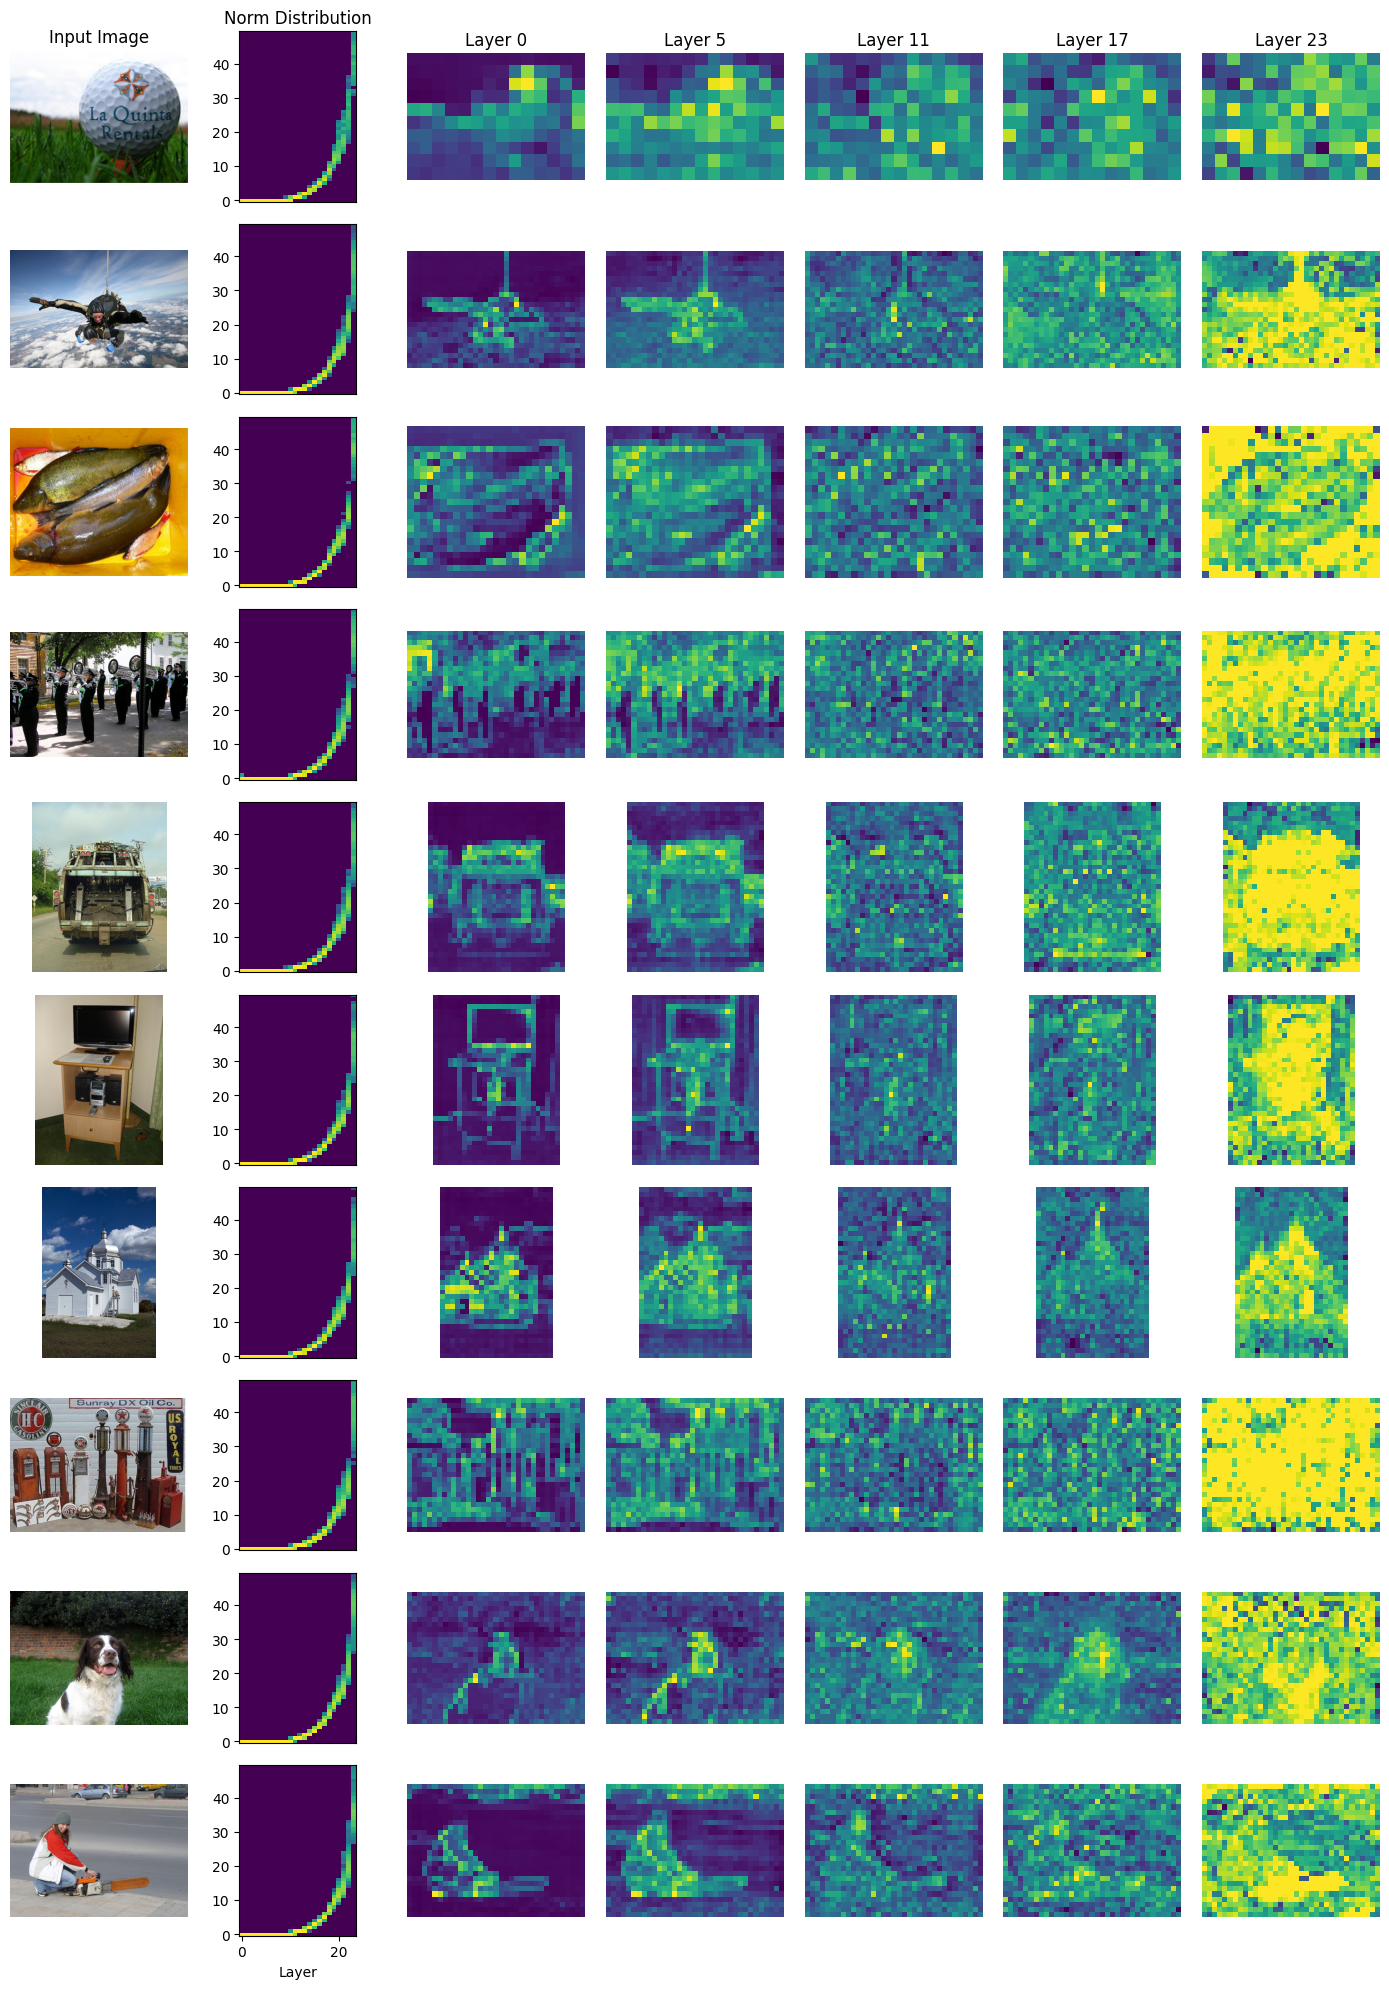

In [ ]:
visualize_attention_maps(dinov2_large_reg,
                         sample_images[:n_samples],
                         layers_to_visualize=(0, 5, 11, 17, 23),
                         show_norms=True,
                         truncate_norms=300)

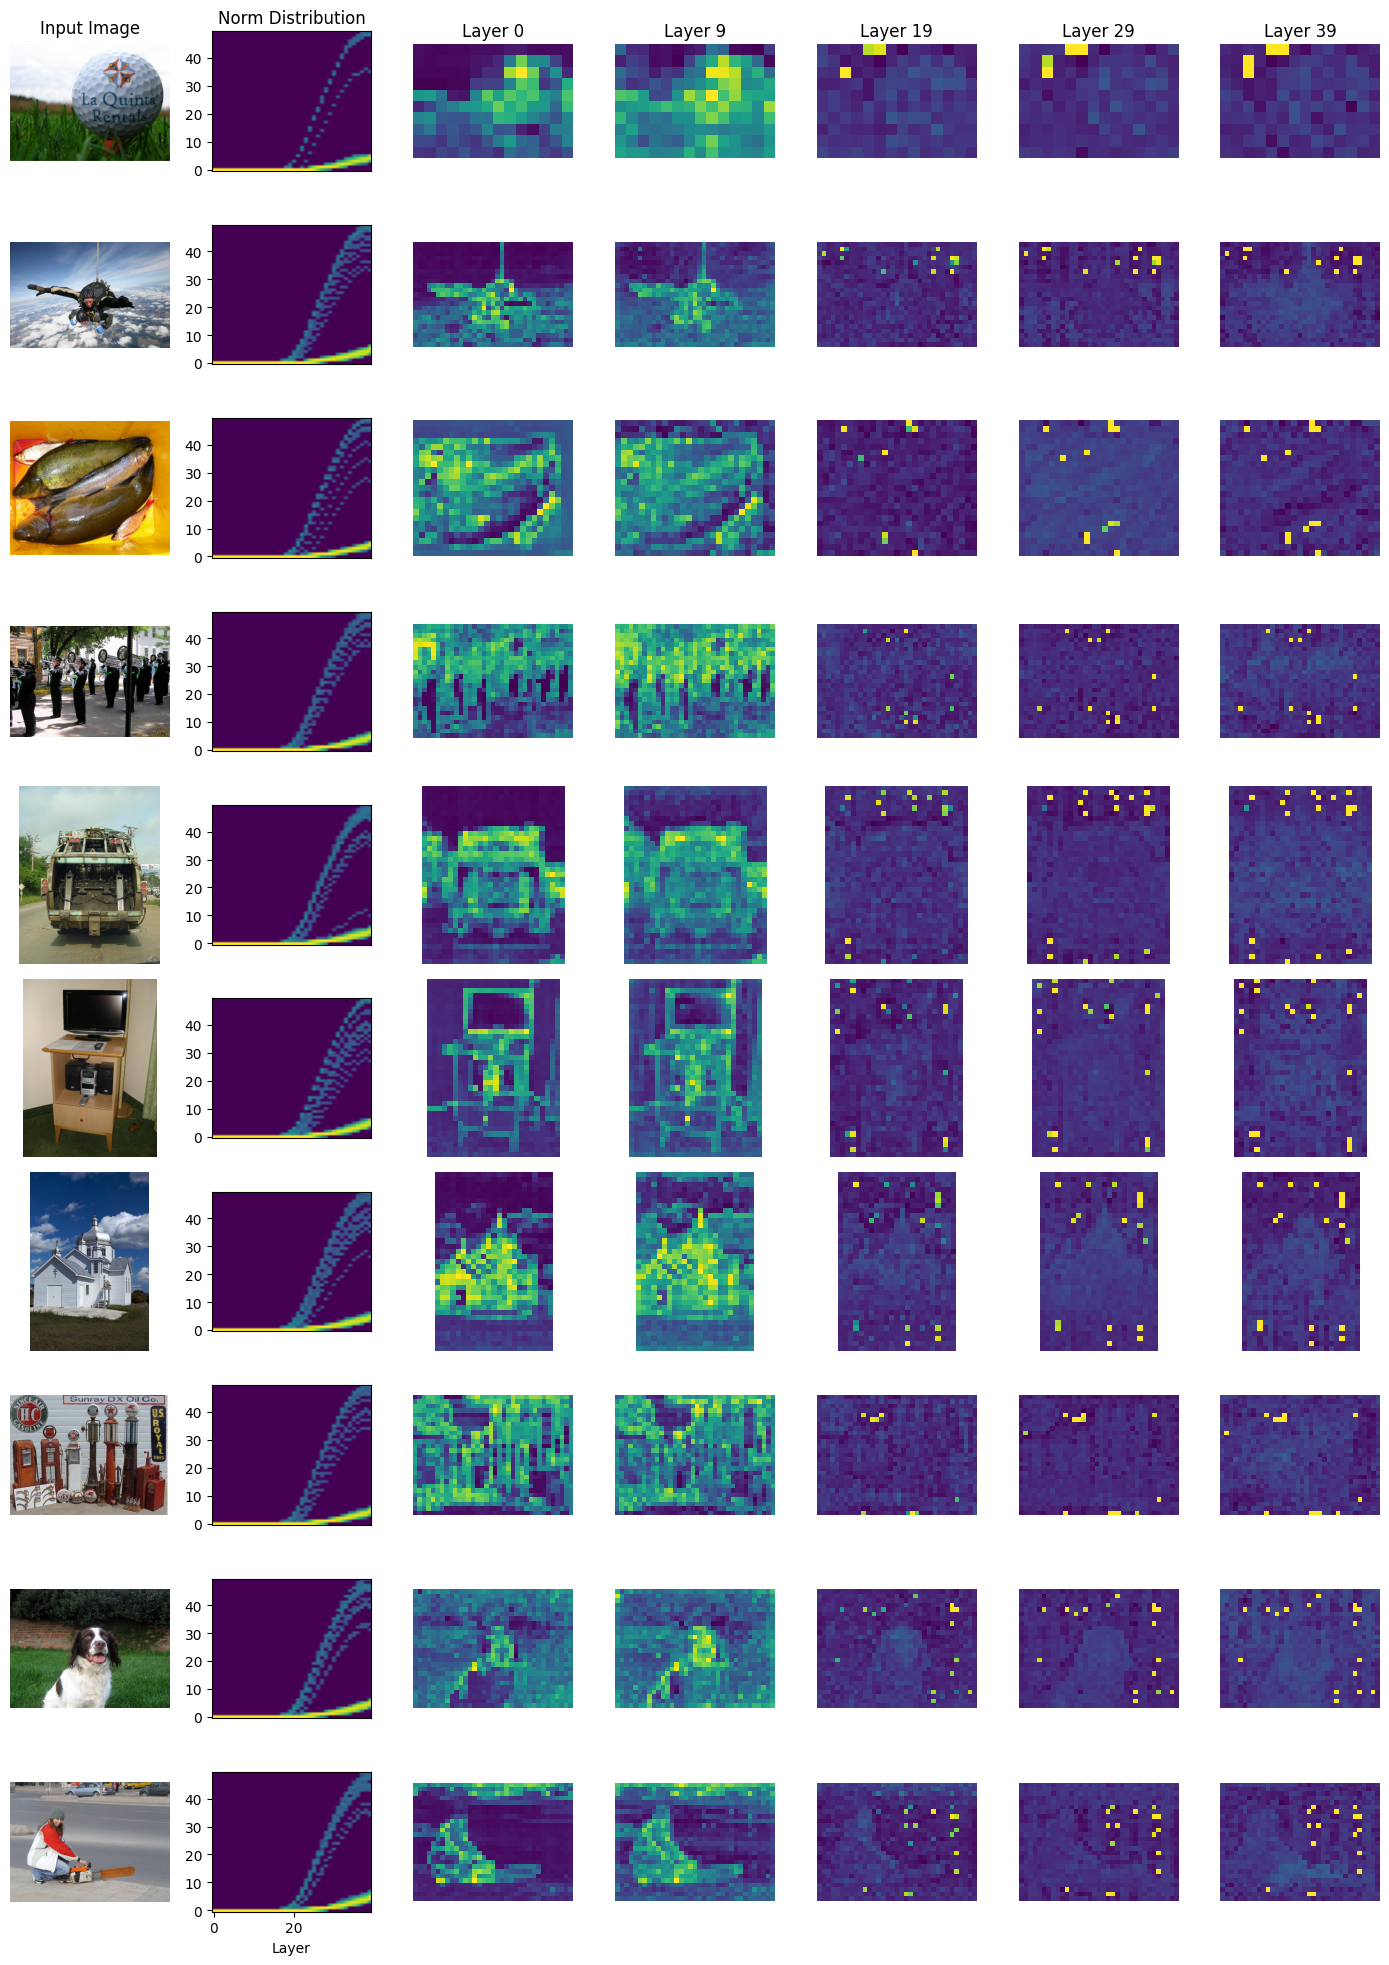

In [ ]:
visualize_attention_maps(dinov2_giant,
                         sample_images[:n_samples],
                         layers_to_visualize=(0, 9, 19, 29, 39),
                         show_norms=True,
                         truncate_norms=300)

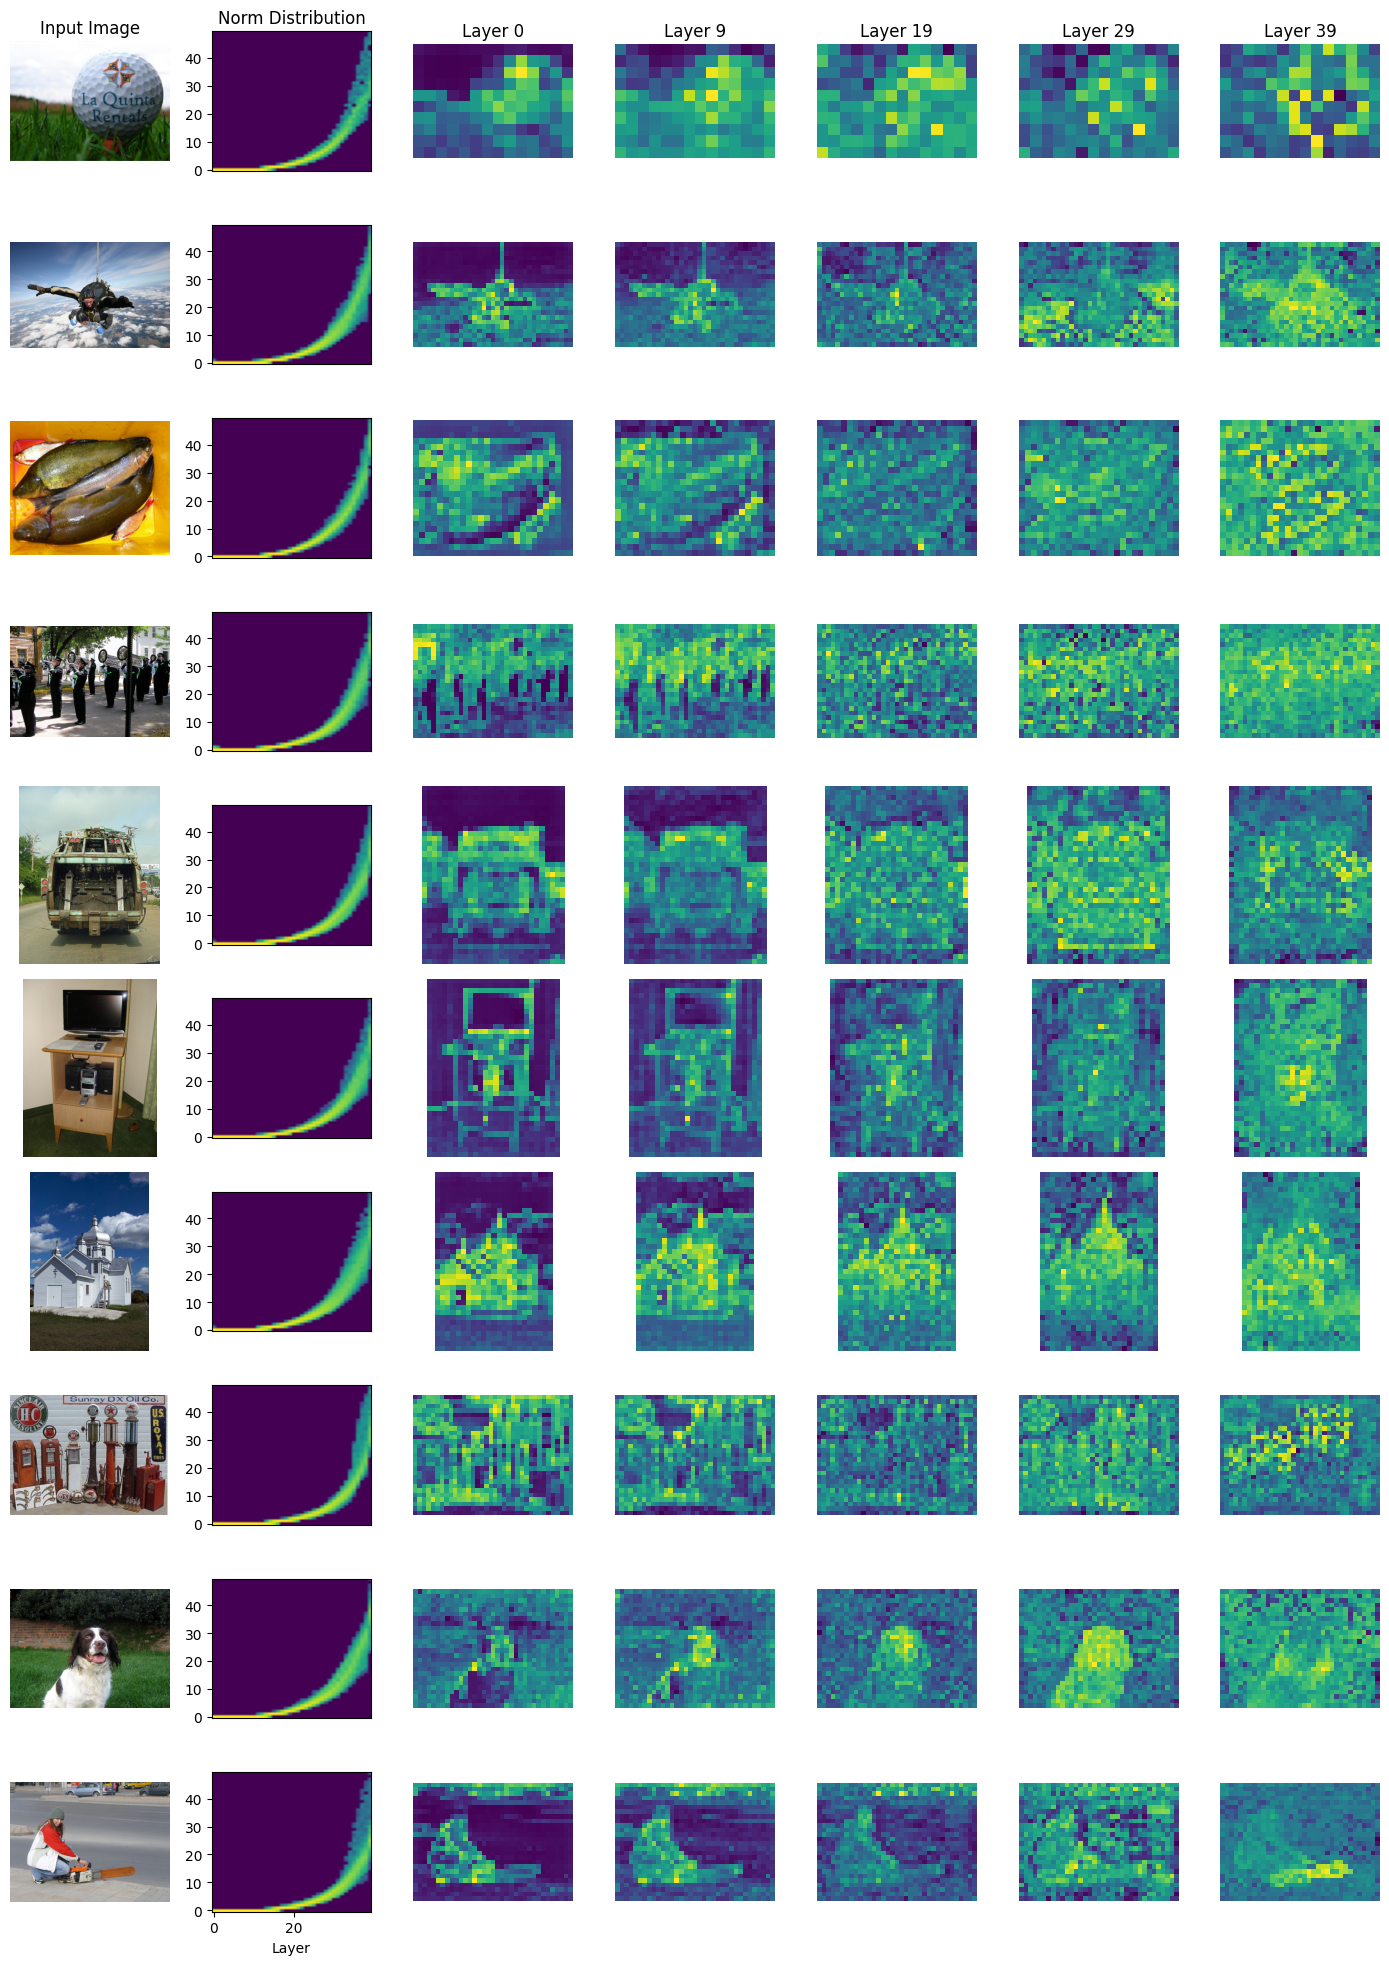

In [ ]:
visualize_attention_maps(dinov2_giant_reg,
                          sample_images[:n_samples],
                          layers_to_visualize=(0, 9, 19, 29, 39),
                          truncate_norms=300,
                          show_norms=True)

For DINOv2 large artifacts appear very suddenly in layer 17. However, looking at the normal curves reveals that the effect is mainly visual

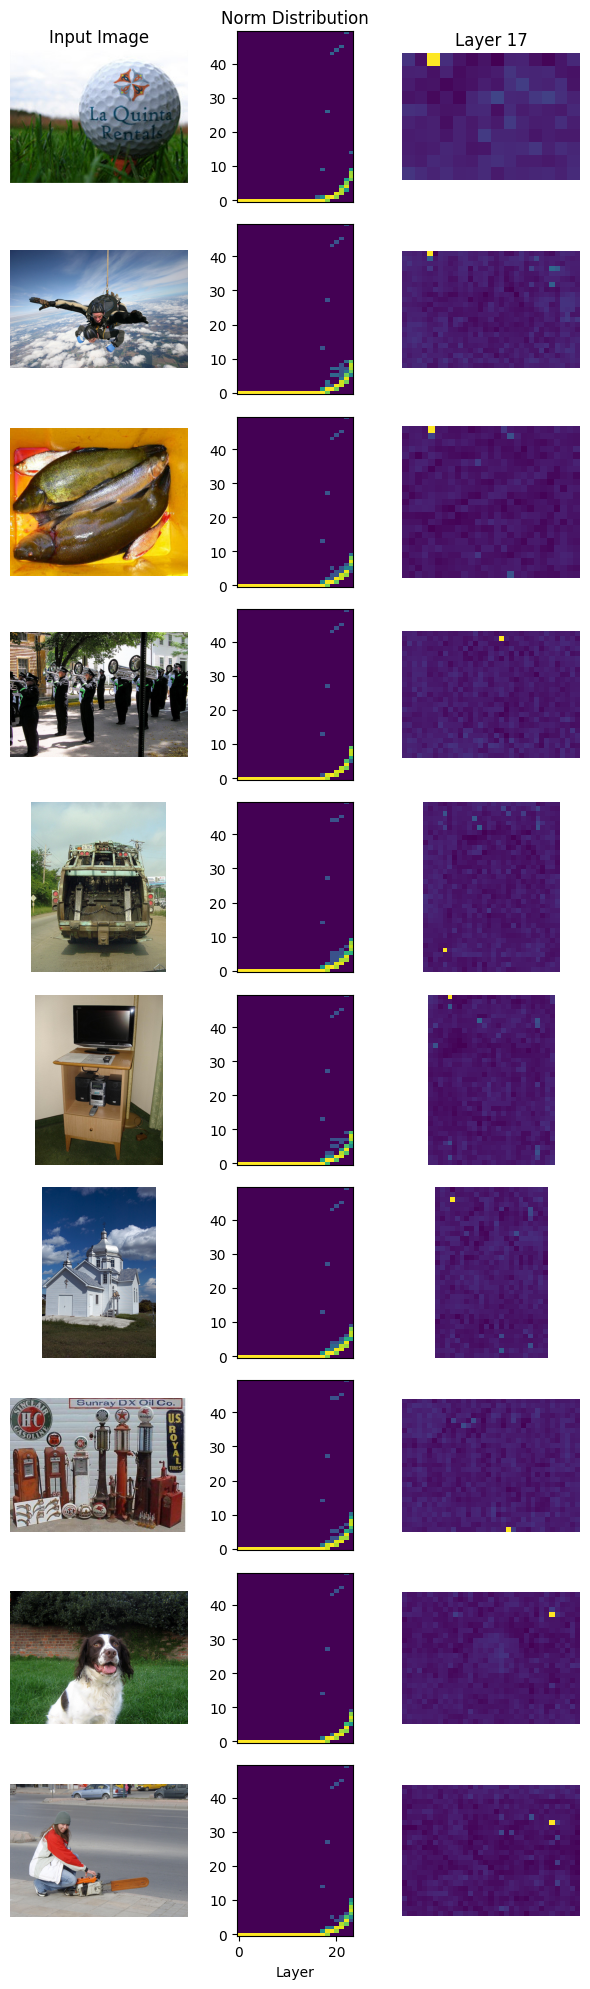

In [ ]:
visualize_attention_maps(dinov2_large,
                         sample_images[:10],
                         layers_to_visualize=[17],
                         show_norms=True,
                         truncate_norms=300)

## Quantative Analysis

In [11]:
sample_images_large = [preprocess_batch(Image.open(path).convert("RGB")) for folder in image_paths for path in folder[:100]]
sample_images_large = torch.tensor(np.array(sample_images_large))
sample_images_batched = sample_images_large.split(32)

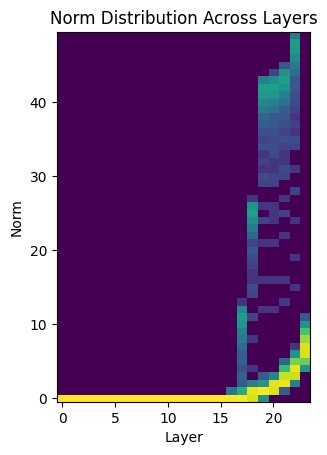

In [ ]:
visualize_average_norms(dinov2_large, sample_images_batched)

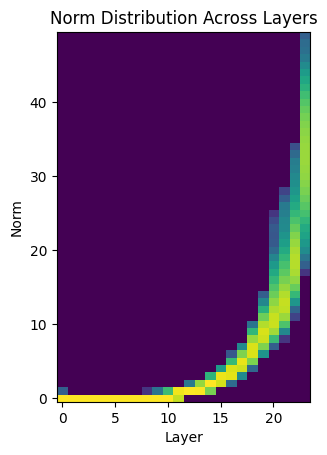

In [ ]:
visualize_average_norms(dinov2_large_reg, sample_images_batched)

/usr/local/lib/python3.10/dist-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/usr/local/lib/python3.10/dist-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


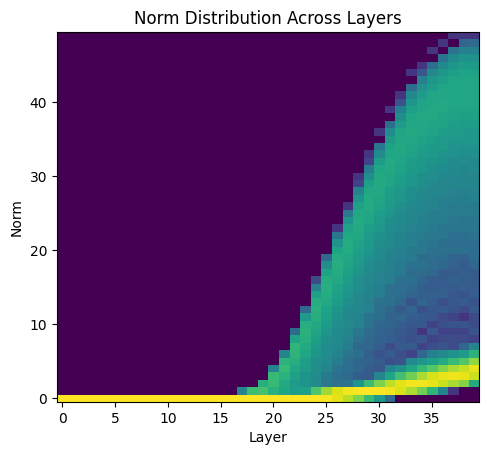

In [15]:
visualize_average_norms(dinov2_giant, sample_images_batched)

/usr/local/lib/python3.10/dist-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/usr/local/lib/python3.10/dist-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


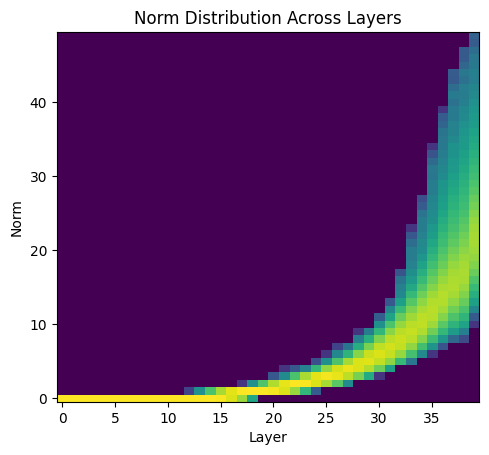

In [12]:
visualize_average_norms(dinov2_giant_reg, sample_images_batched)

## Free up memory

In [ ]:
del dinov2_large

In [ ]:
del dinov2_large_reg

In [16]:
del dinov2_giant

In [ ]:
del dinov2_giant_reg

In [17]:
torch.cuda.empty_cache()